# Ordinal Logistic analysis with `pm.OrderedLogistic`

This notebook is an exploration of ordinal regression. It has been influenced by a chapter in Doing Bayesian Data Analysis (2nd edition) by Kruschke, and also by input from Adrian Seyboldt. 

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import theano.tensor as at

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 1234

Define utility functions

In [3]:
def calc_edges(observations):
    """
    return edges for an observed vector of integer bin counts
    K = number of cutpoints
    """
    return np.linspace(np.min(observations), np.max(observations)+1, K+2) - 0.5

In [4]:
def calc_y_stats(pp_y, K):
    """from a set of posterior predicted observations, return percentiles"""
    pp_samples = pp_y.shape[0]
    counts = np.zeros((pp_samples,K+1))
    for i in range(pp_samples):
        counts[i,:] = np.bincount(pp_y[i,:])
    return np.percentile(counts, [2.5, 50, 97.5], axis=0)

# Single group

First we generate some observed data

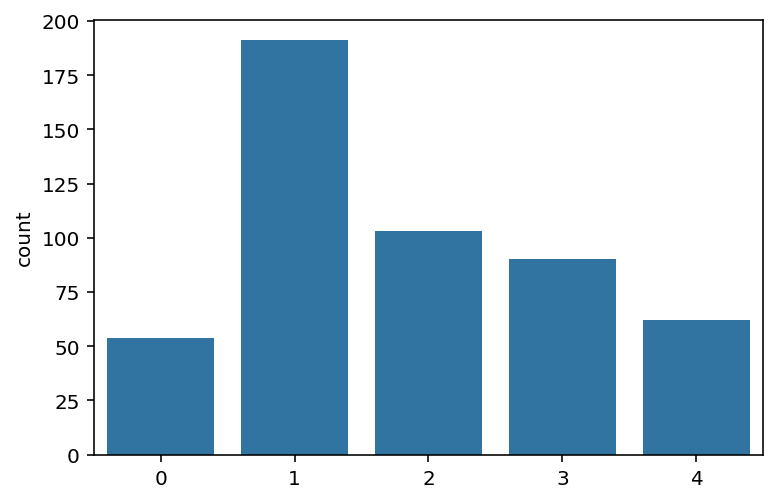

In [5]:
# define distribution
true_eta = 0
true_cutpoints = [-2, 0, 1, 2]
K = len(true_cutpoints)
dist = pm.OrderedLogistic.dist(cutpoints=true_cutpoints, eta=true_eta)
# generate samples
y = dist.random(size=500)
# plot
sns.countplot(x=y, color='C0');

## Model 1: Cutpoints are unknown, eta is fixed

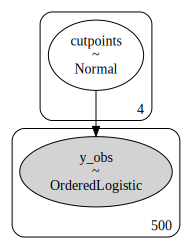

In [6]:
with pm.Model() as model:
    cutpoints = pm.Normal("cutpoints", mu=[-1,-0.5, 0.5, 1], sigma=10, shape=4,
                          transform=pm.distributions.transforms.ordered)
    pm.OrderedLogistic("y_obs", cutpoints=cutpoints, eta=0, observed=y)
    
pm.model_to_graphviz(model)

In [7]:
with model:
    # samples
    trace = pm.sample(return_inferencedata=True)
    # posterior predictive
    ppc = pm.sample_posterior_predictive(trace, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


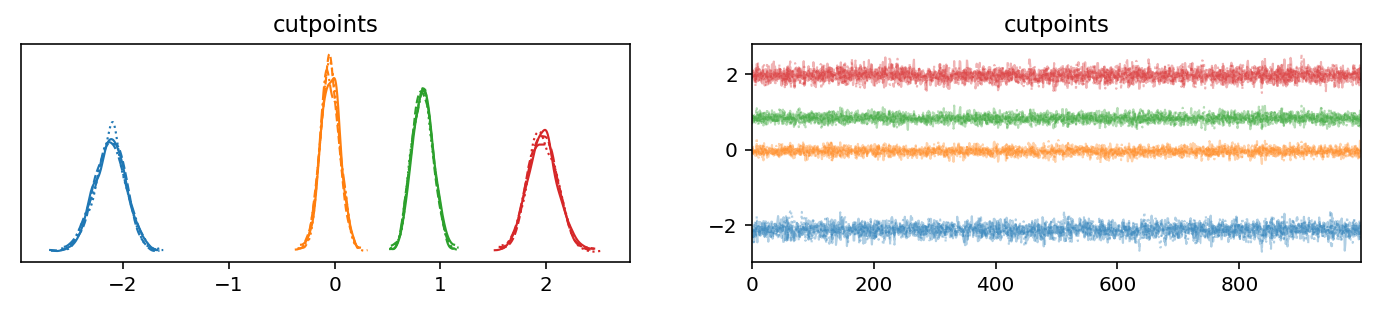

In [8]:
az.plot_trace(trace);

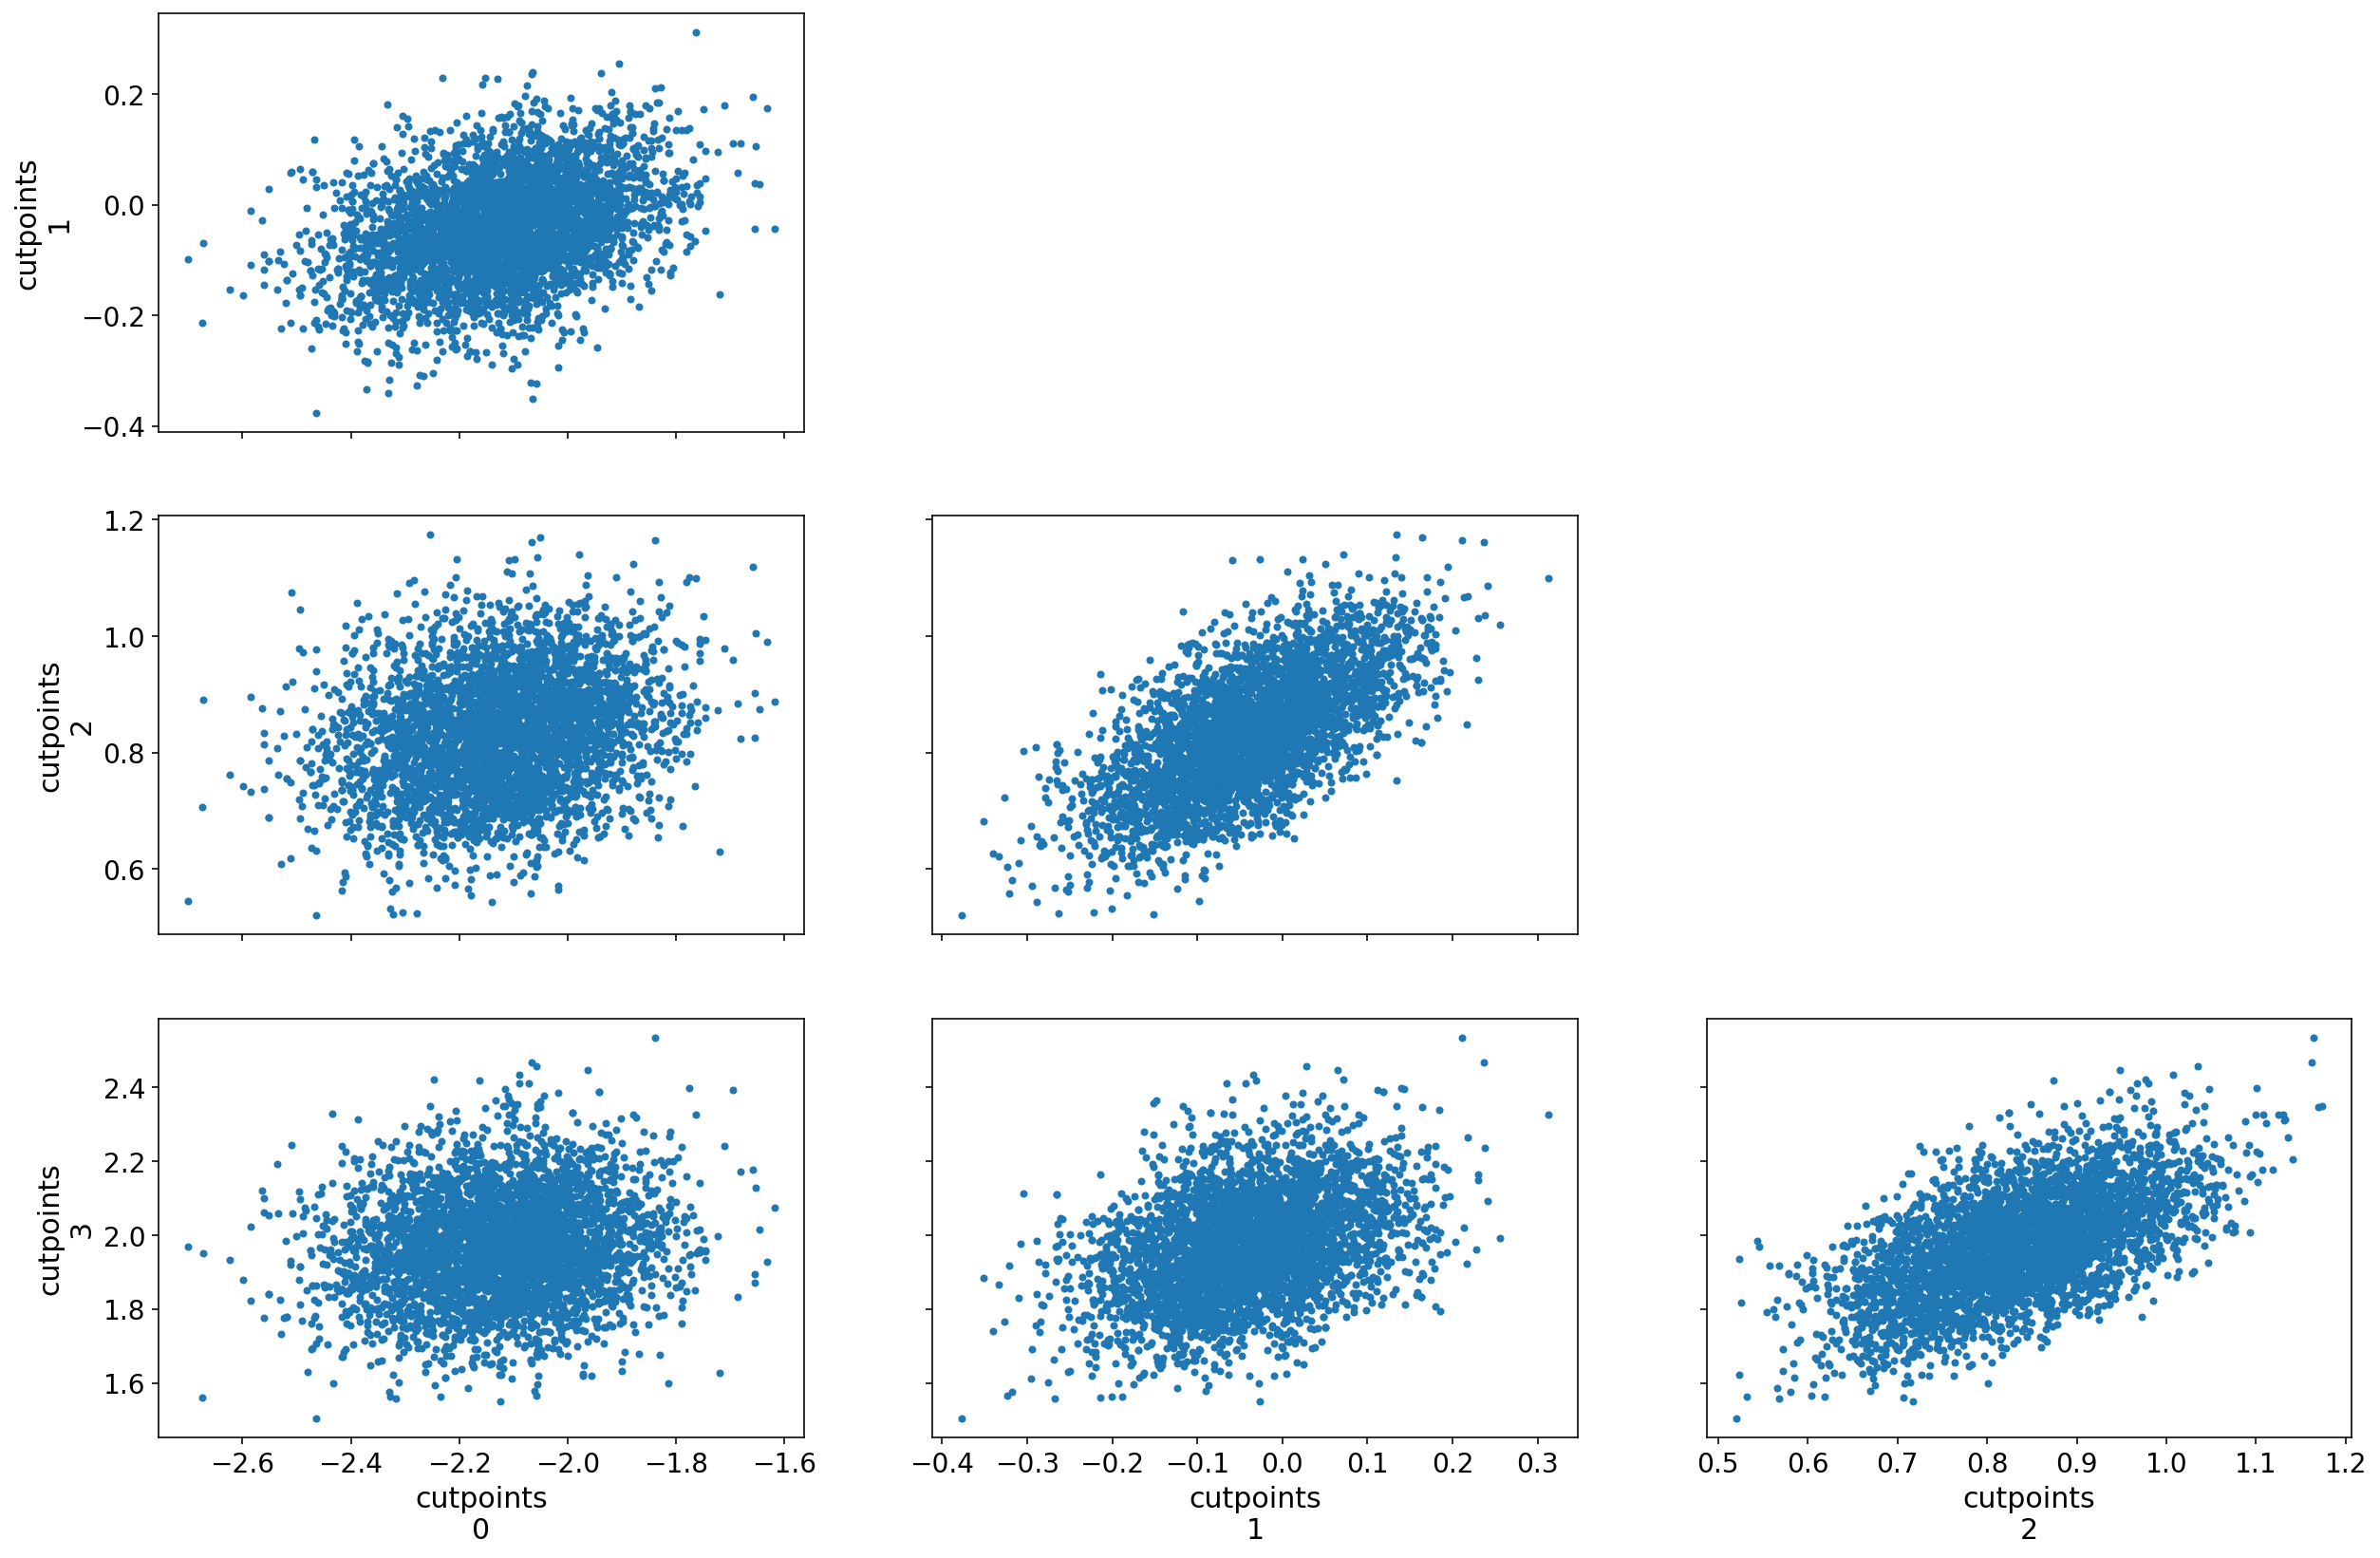

In [9]:
az.plot_pair(trace);

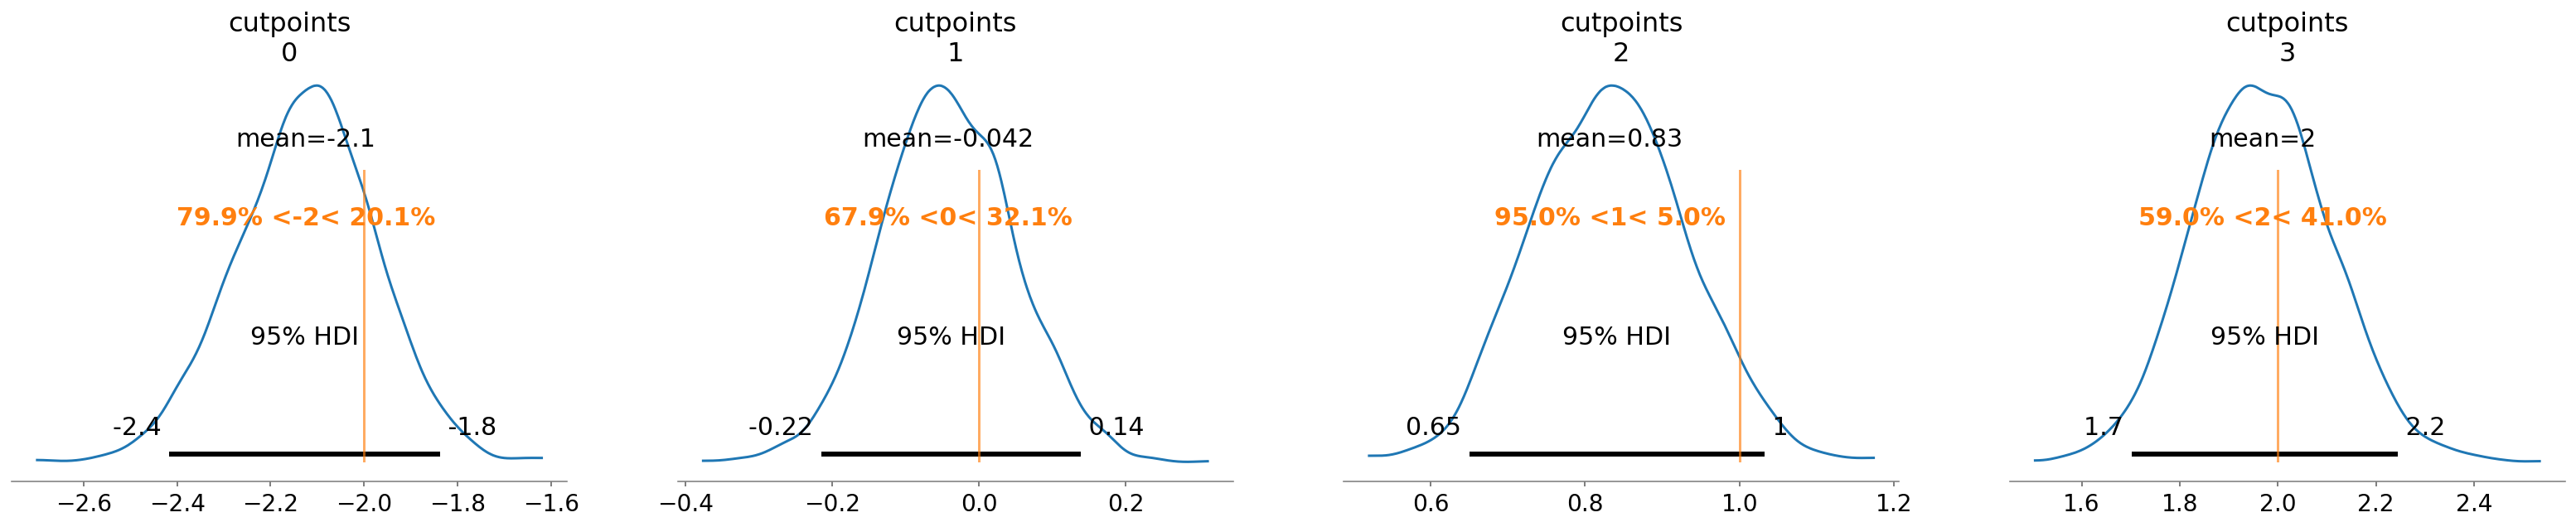

In [10]:
az.plot_posterior(trace, hdi_prob=0.95, ref_val=true_cutpoints);

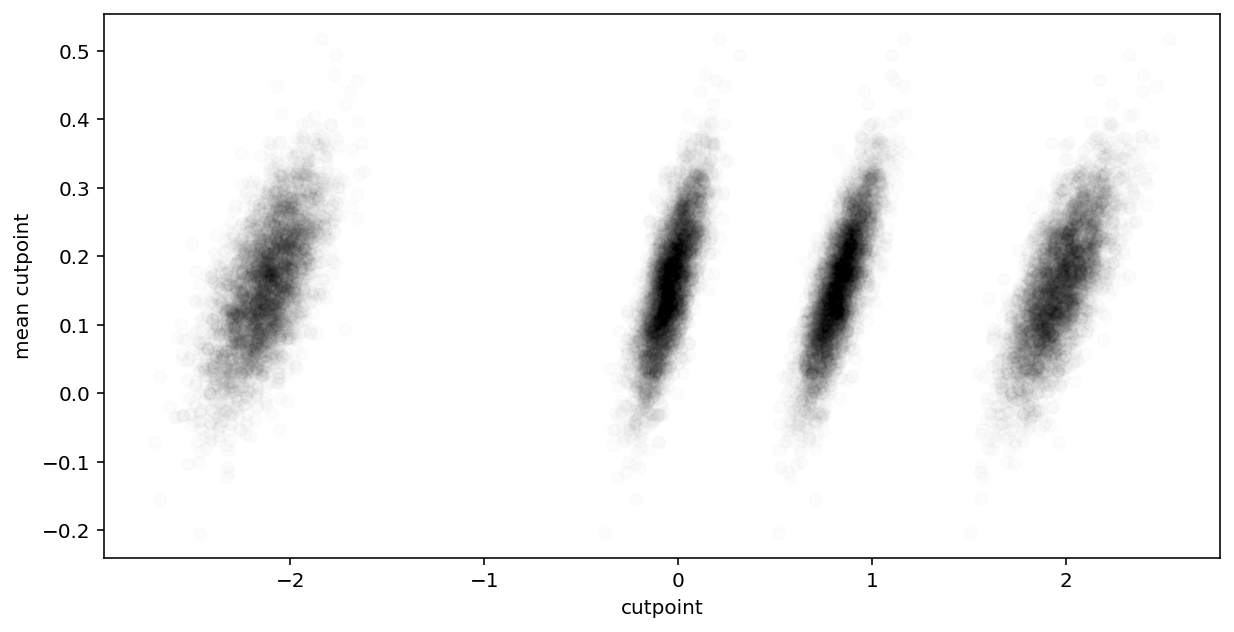

In [11]:
# Kruschke style plot
cutpoints = trace.posterior.cutpoints.stack(sample=["chain", "draw"])
mean = cutpoints.mean(dim="cutpoints_dim_0").values
sorted_indexes = np.argsort(mean)

fig, ax = plt.subplots(figsize=(10,5))
for i in sorted_indexes:
    ax.plot(cutpoints.values[:,i], mean[i]*np.ones((4,1)), 'ko', alpha=0.01)

ax.set(xlabel='cutpoint', ylabel='mean cutpoint');

Posterior predictive

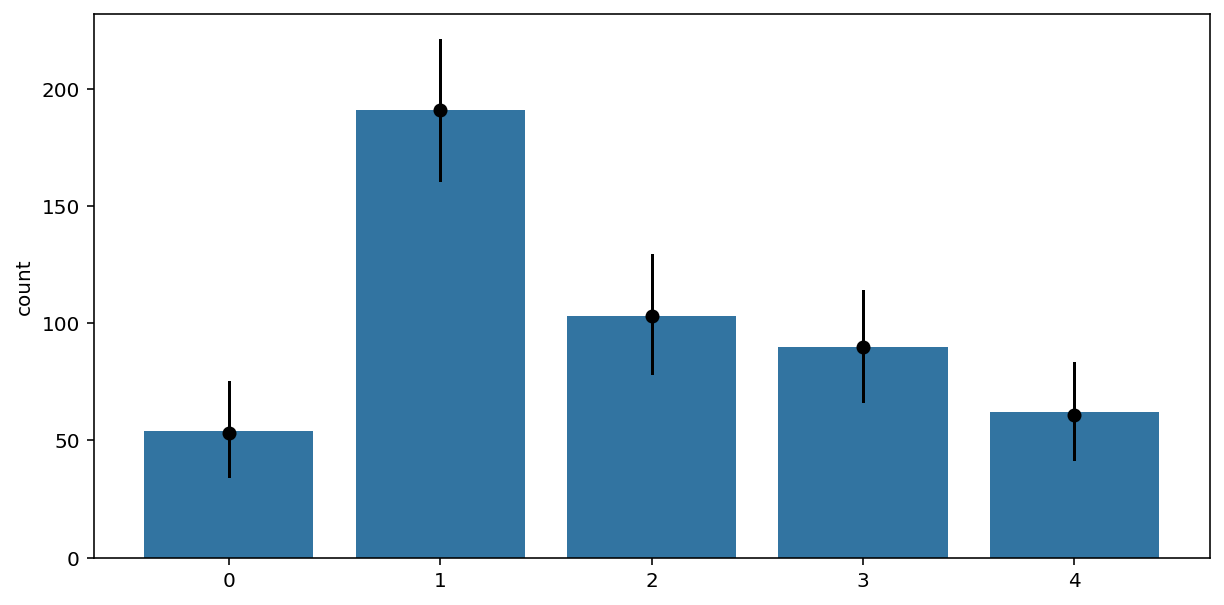

In [12]:
fig, ax = plt.subplots(figsize=(10,5))

# plot observed bin counts
sns.countplot(x=y, color='C0', ax=ax);

# plot errorbars
ypp_stats = calc_y_stats(ppc["y_obs"], K)
ax.plot(ypp_stats[1,:], 'ko')
for i in [0, 1, 2, 3, 4]:
    ax.plot([i, i], [ypp_stats[0,i], ypp_stats[2,i]], 'k')

## Model 2: Eta and cutpoints are unknown
This will be a bad model because we have too many free parameters. This will cause quite a lot of parameter correlation. Although the posterior predictive still looks good, this degree of parameter correlation is undesirable.

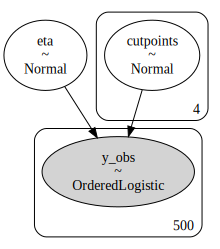

In [13]:
with pm.Model() as model:
    eta = pm.Normal('eta',0, 1)
    cutpoints = pm.Normal("cutpoints", mu=[-1,-0.5, 0.5, 1], sigma=10, shape=4,
                          transform=pm.distributions.transforms.ordered)
    pm.OrderedLogistic("y_obs", cutpoints=cutpoints, eta=eta, observed=y)
    
pm.model_to_graphviz(model)

In [14]:
with model:
    # samples
    trace = pm.sample(return_inferencedata=True)
    # posterior predictive
    ppc = pm.sample_posterior_predictive(trace, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoints, eta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


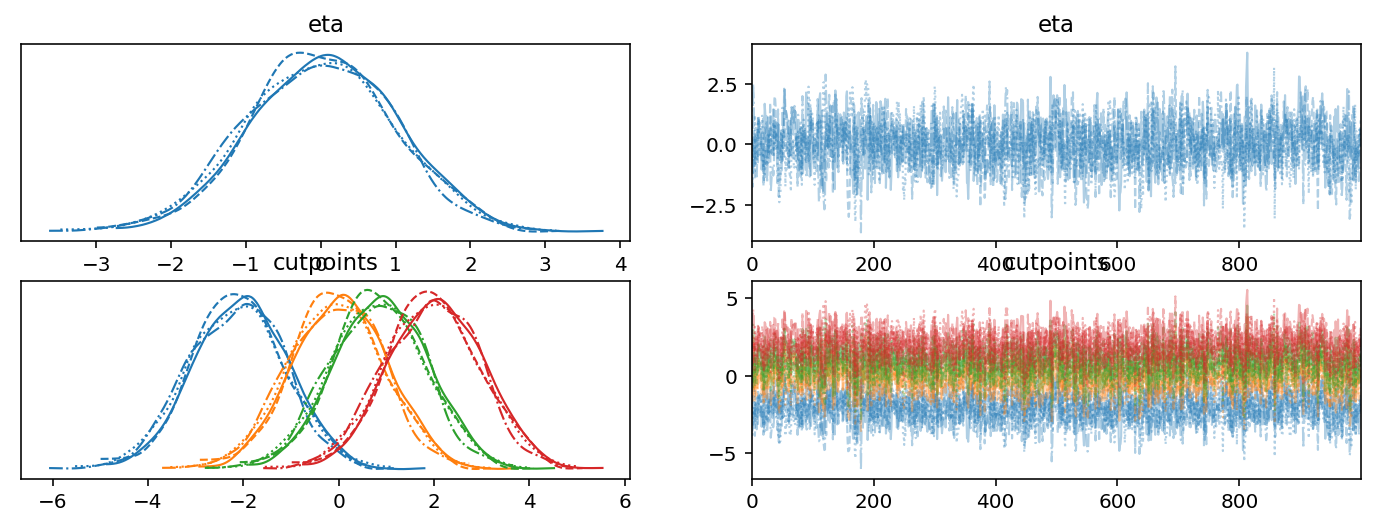

In [15]:
az.plot_trace(trace);

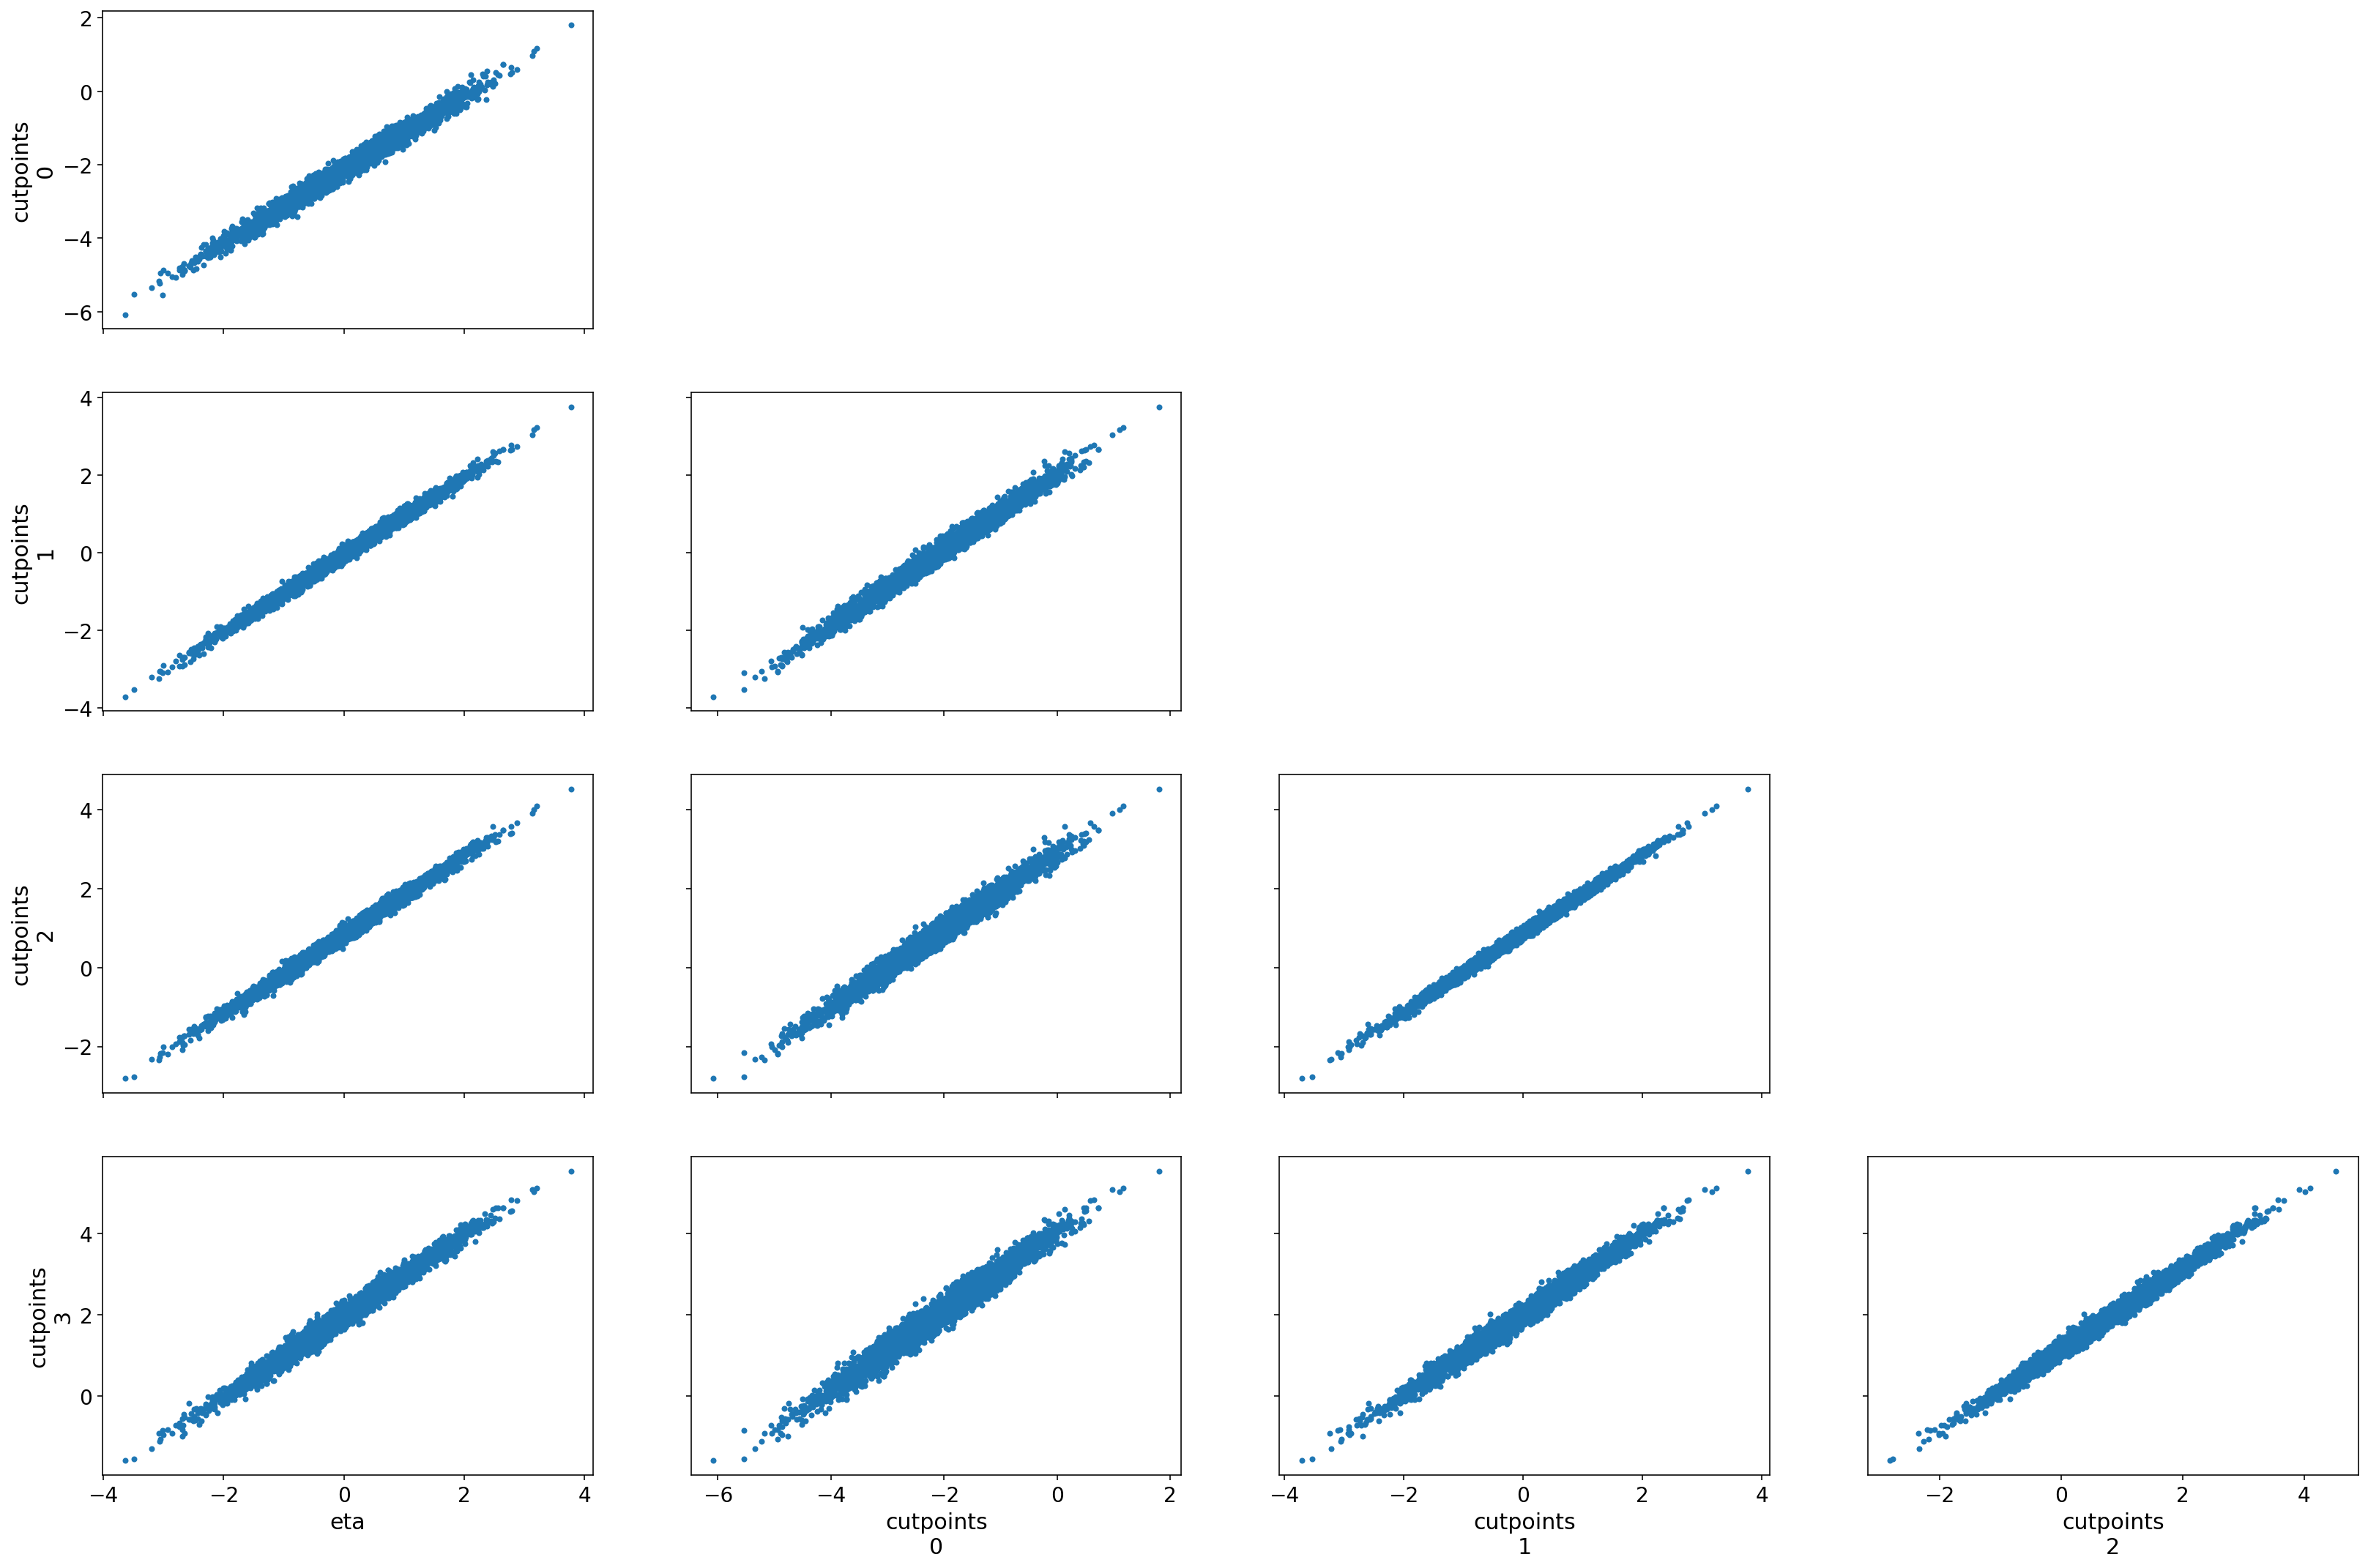

In [16]:
az.plot_pair(trace);

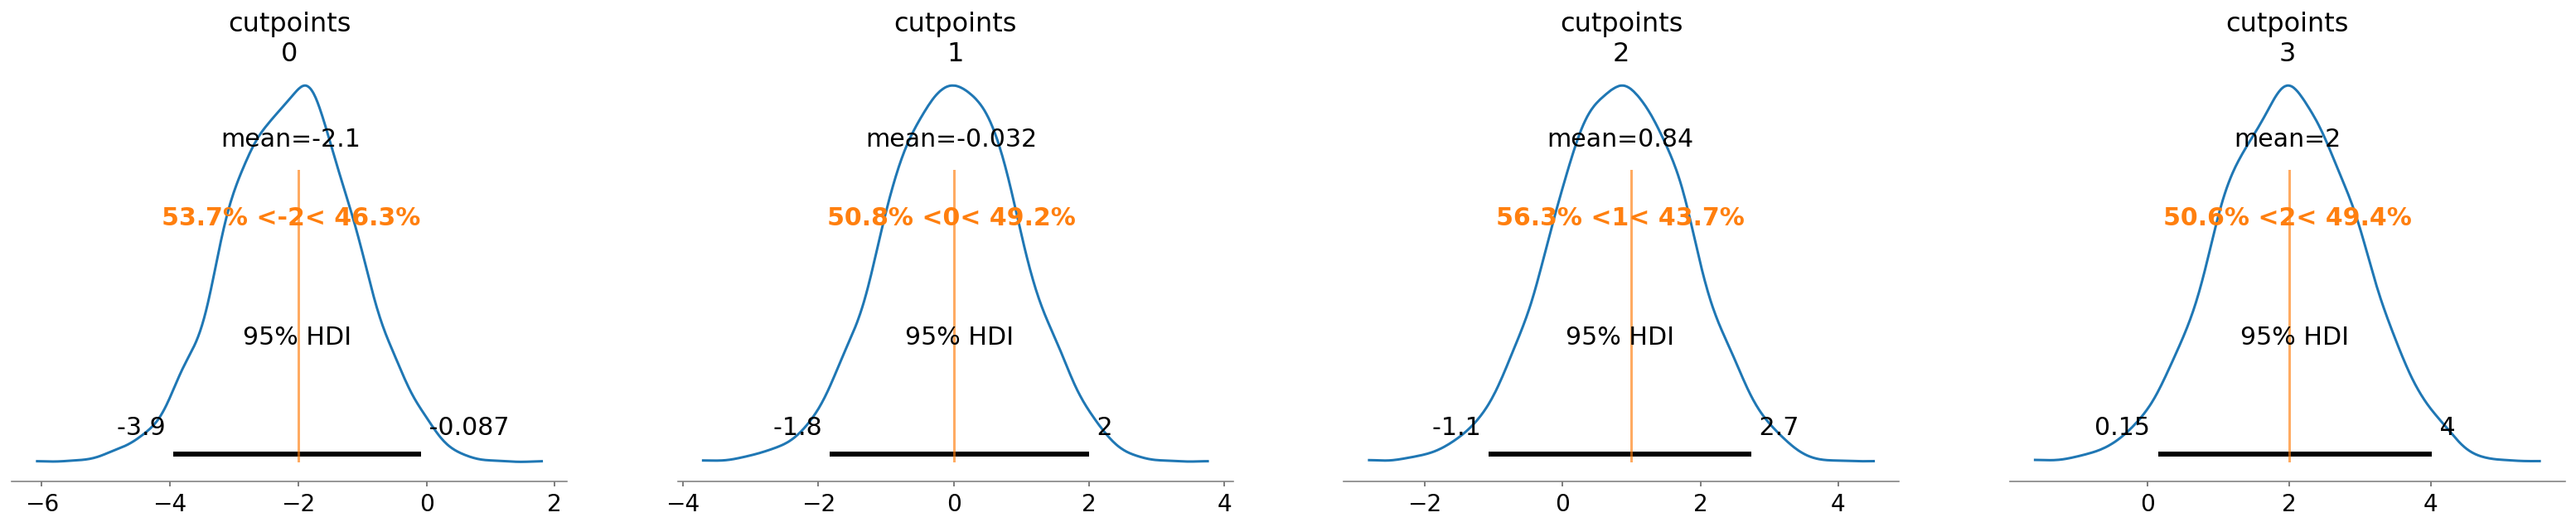

In [17]:
az.plot_posterior(trace, hdi_prob=0.95, var_names='cutpoints', ref_val=true_cutpoints);

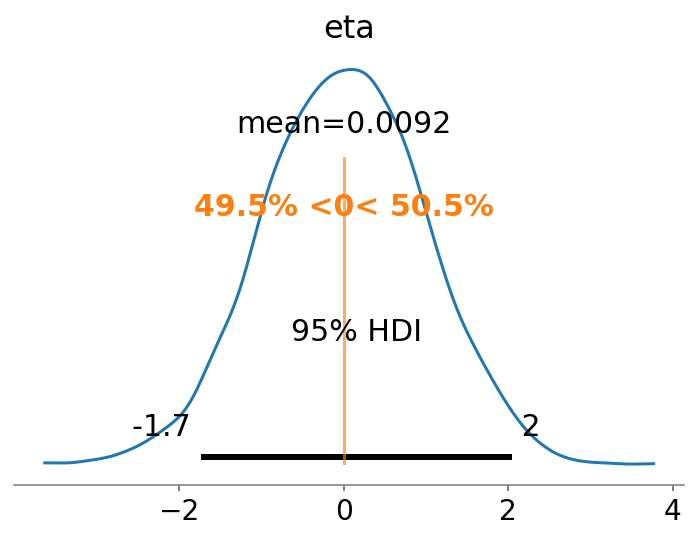

In [18]:
az.plot_posterior(trace, hdi_prob=0.95, var_names='eta', ref_val=true_eta);

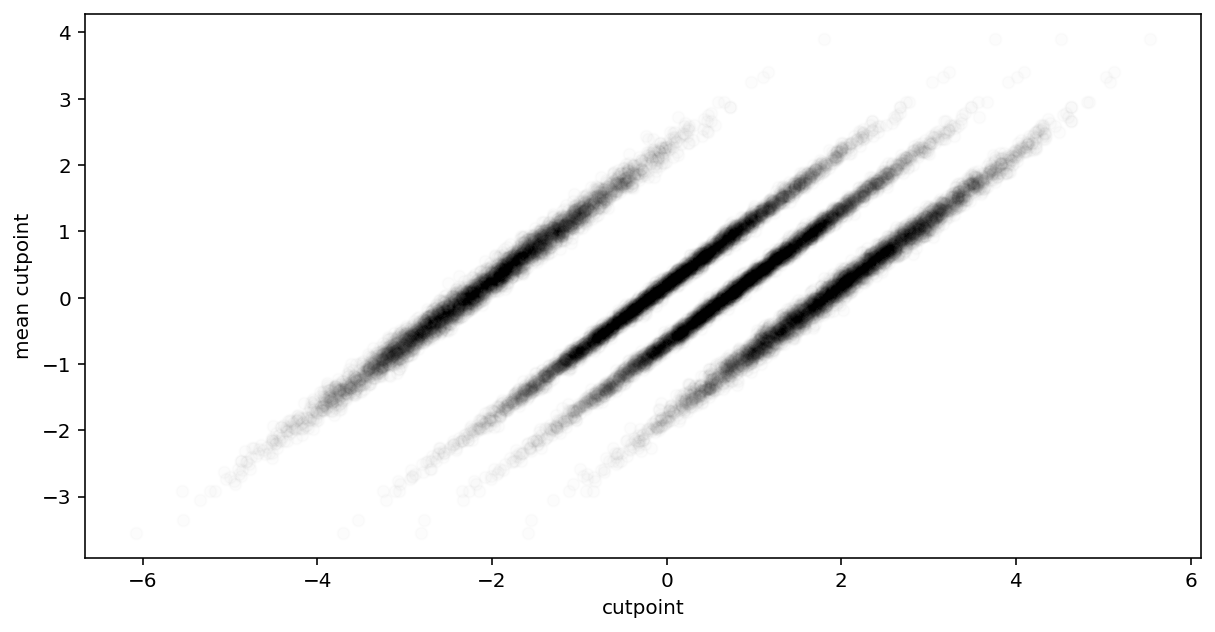

In [19]:
# Kruschke style plot
cutpoints = trace.posterior.cutpoints.stack(sample=["chain", "draw"])
mean = cutpoints.mean(dim="cutpoints_dim_0").values
sorted_indexes = np.argsort(mean)

fig, ax = plt.subplots(figsize=(10,5))
for i in sorted_indexes:
    ax.plot(cutpoints.values[:,i], mean[i]*np.ones((4,1)), 'ko', alpha=0.01)

ax.set(xlabel='cutpoint', ylabel='mean cutpoint');

Posterior prediction

In [20]:
K

4

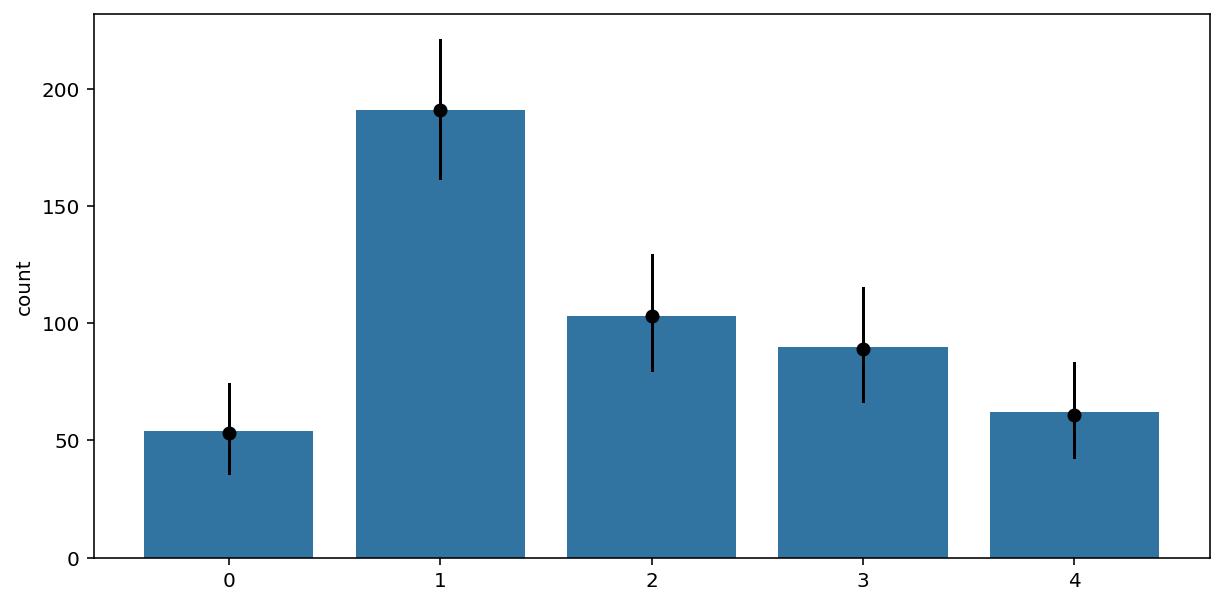

In [21]:
fig, ax = plt.subplots(figsize=(10,5))

# plot observed bin counts
sns.countplot(x=y, color='C0', ax=ax);

# plot errorbars
ypp_stats = calc_y_stats(ppc["y_obs"], K)
ax.plot(ypp_stats[1,:], 'ko')
for i in [0, 1, 2, 3, 4]:
    ax.plot([i, i], [ypp_stats[0,i], ypp_stats[2,i]], 'k')

## Model 3: can we fix this by constraining the first cutpoint to be zero?

In [22]:
K

4

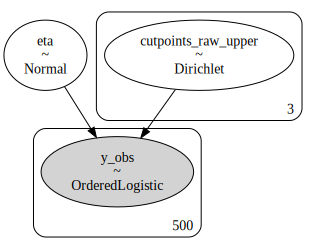

In [23]:
with pm.Model() as model:
    eta = pm.Normal('eta',0, 1)
    
    cutpoints = at.concatenate([
        np.zeros(1),
        pm.Dirichlet("cutpoints_raw_upper", a=np.ones(K - 1))
    ])  
    pm.OrderedLogistic("y_obs", cutpoints=cutpoints*2, eta=eta, observed=y)
    
pm.model_to_graphviz(model)

# *** THIS DOES NOT WORK ***

In [24]:
# with model:
#     trace = pm.sample(return_inferencedata=True)
#     ppc = pm.sample_posterior_predictive(trace, random_seed=RANDOM_SEED)
# 
# az.plot_pair(trace);

# Two groups
Generate data

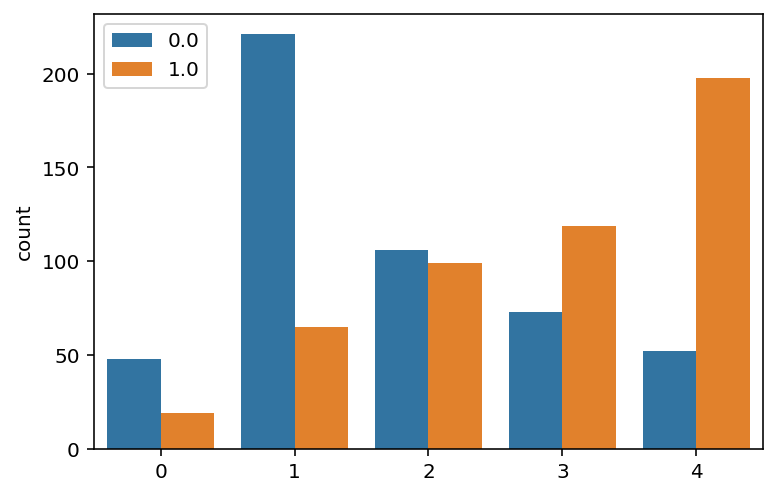

In [25]:
N = 500
group = np.concatenate((np.zeros(N), np.ones(N)))

# define distribution
true_eta = [0, 1.5]
true_cutpoints = [-2, 0, 1, 2]
K = len(true_cutpoints)
y = np.concatenate((pm.OrderedLogistic.dist(cutpoints=true_cutpoints, eta=true_eta[0]).random(size=N),
                    pm.OrderedLogistic.dist(cutpoints=true_cutpoints, eta=true_eta[1]).random(size=N)))
# plot
sns.countplot(x=y, hue=group);

## Model 1
Ok for groups = {0, 1}

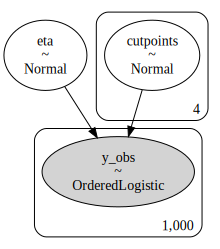

In [26]:
with pm.Model() as model:
    group_effect = pm.Normal('eta', 0, 1)
    cutpoints = pm.Normal("cutpoints", mu=[-1,-0.5, 0.5, 1], sigma=10, shape=4,
                          transform=pm.distributions.transforms.ordered)
    # could use ZeroSumNormal also
    mu = group_effect * group  # works when group = {0, 1}
    pm.OrderedLogistic("y_obs", cutpoints=cutpoints, eta=mu, observed=y)
    
pm.model_to_graphviz(model)

In [27]:
with model:
    # samples
    trace = pm.sample(return_inferencedata=True)
    # posterior predictive
    ppc = pm.sample_posterior_predictive(trace, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoints, eta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


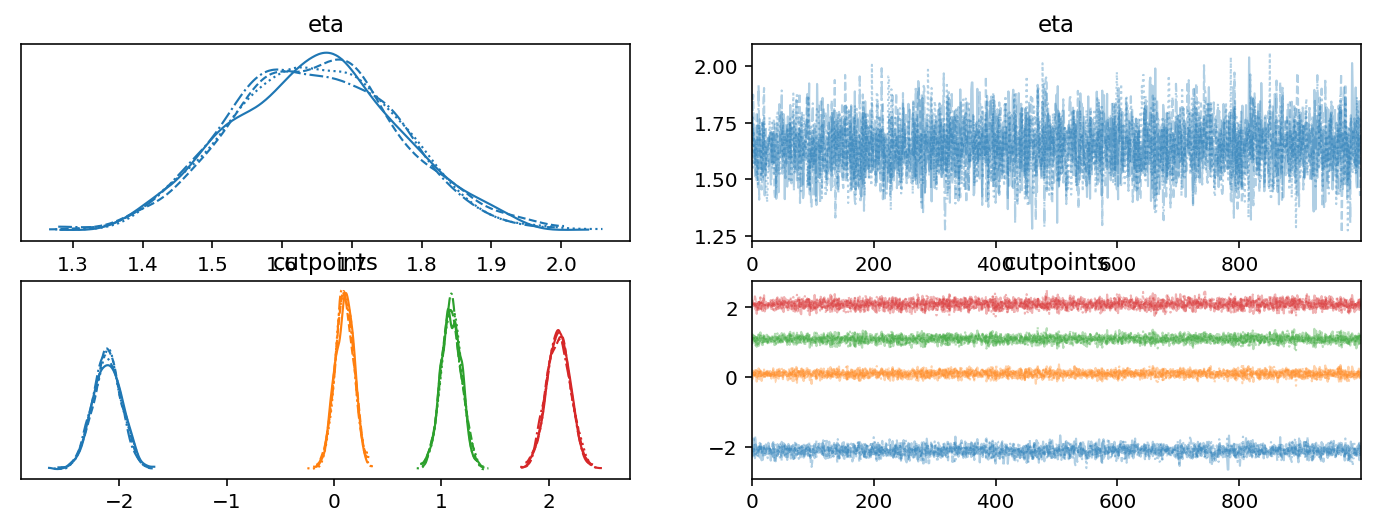

In [28]:
az.plot_trace(trace);

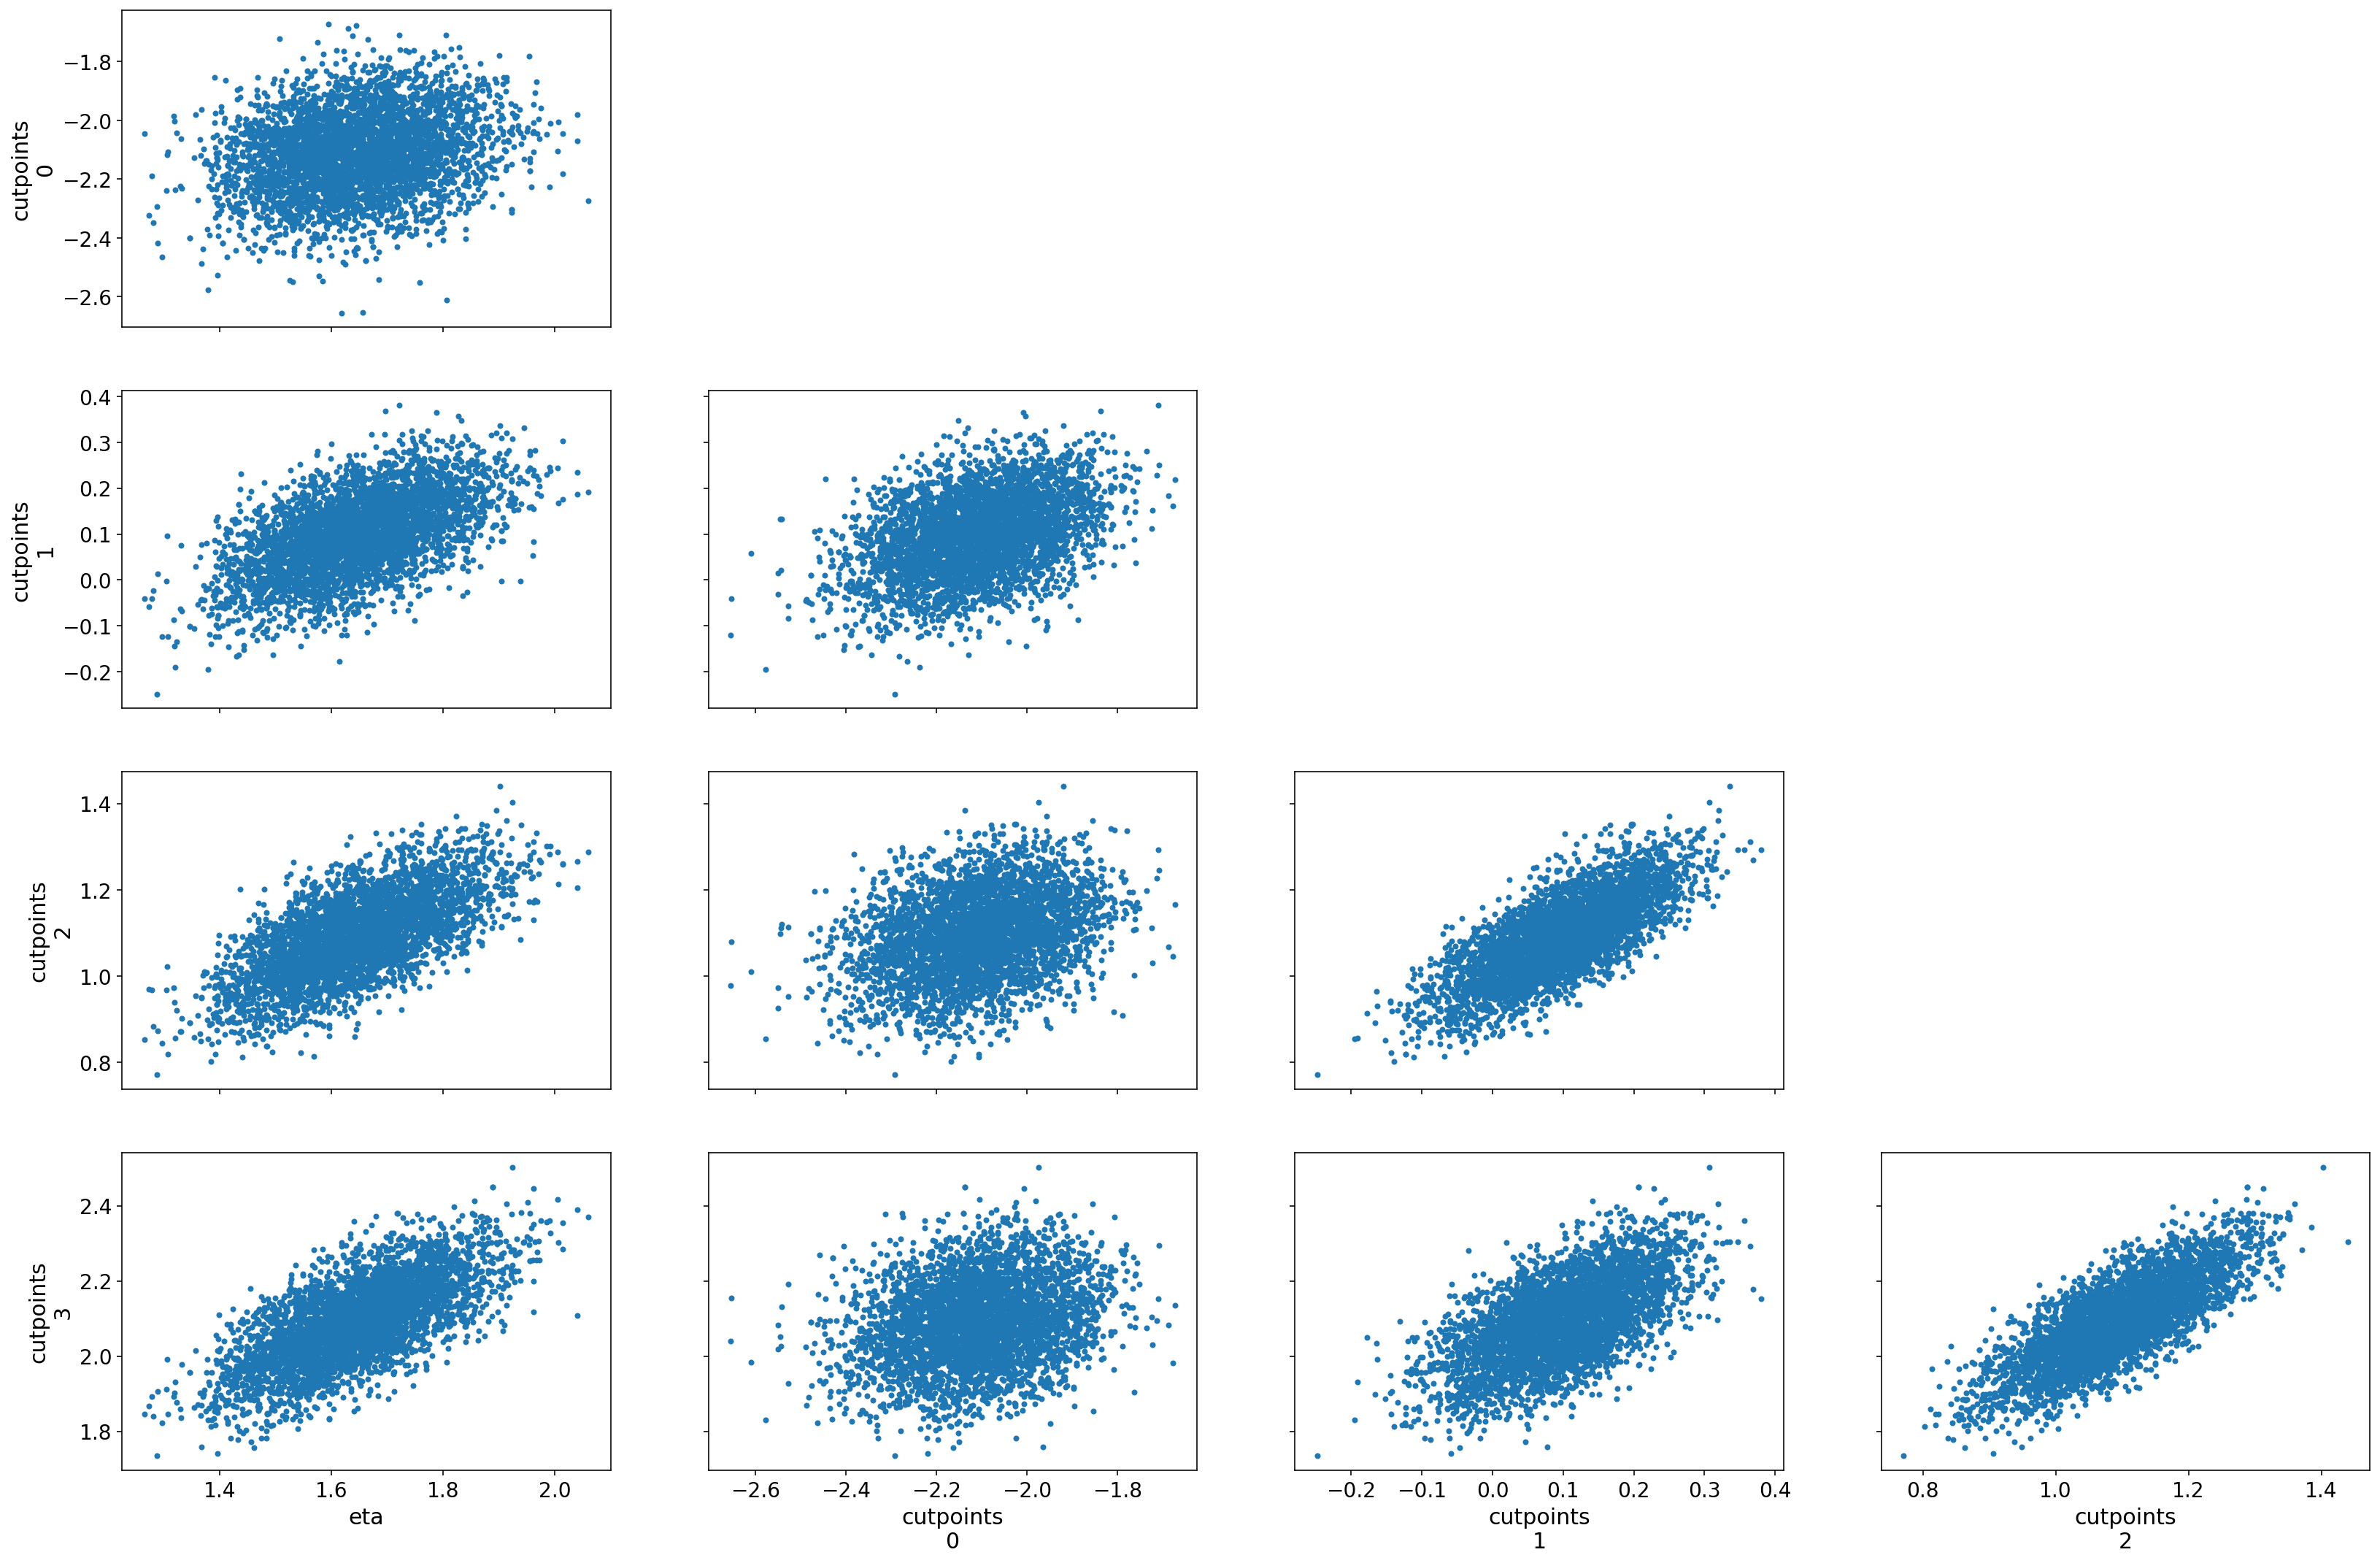

In [29]:
az.plot_pair(trace);

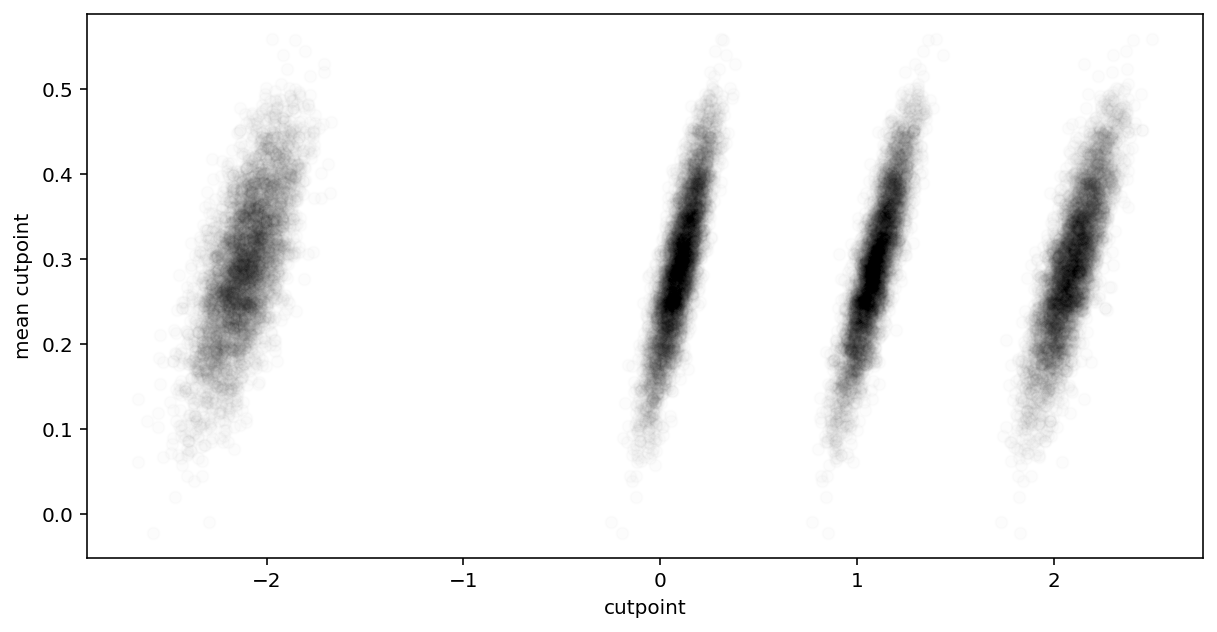

In [30]:
# Kruschke style plot
cutpoints = trace.posterior.cutpoints.stack(sample=["chain", "draw"])
mean = cutpoints.mean(dim="cutpoints_dim_0").values
sorted_indexes = np.argsort(mean)

fig, ax = plt.subplots(figsize=(10,5))
for i in sorted_indexes:
    ax.plot(cutpoints.values[:,i], mean[i]*np.ones((4,1)), 'ko', alpha=0.01)

ax.set(xlabel='cutpoint', ylabel='mean cutpoint');

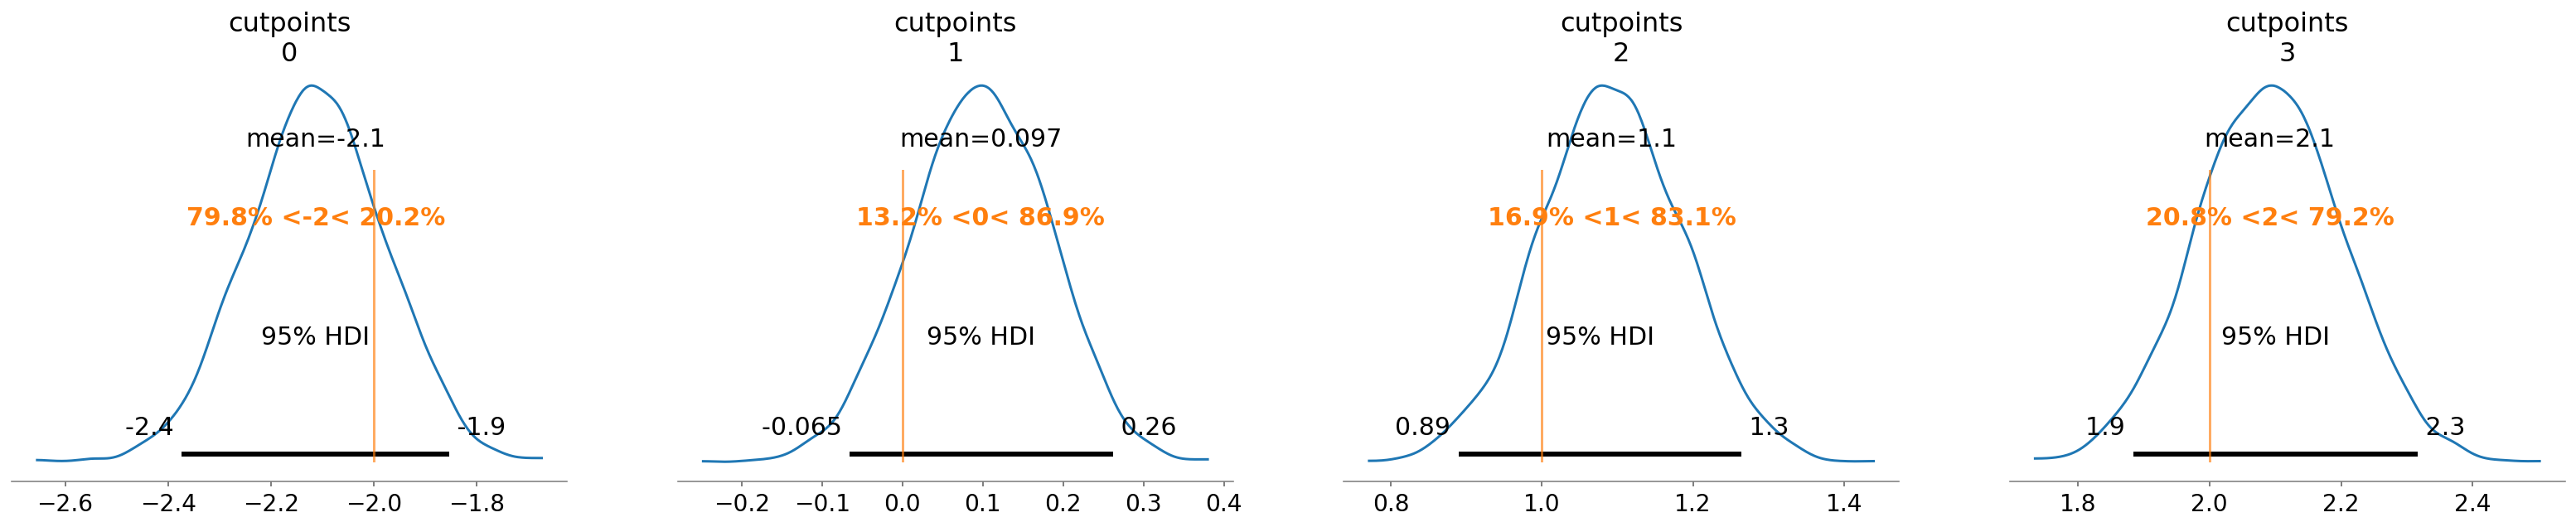

In [31]:
az.plot_posterior(trace, hdi_prob=0.95, var_names='cutpoints', ref_val=true_cutpoints);

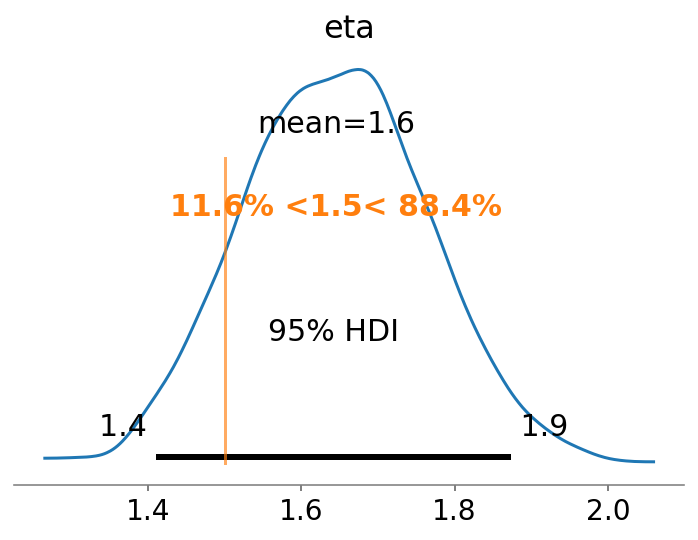

In [32]:
az.plot_posterior(trace, hdi_prob=0.95, var_names='eta', ref_val=true_eta[1]);

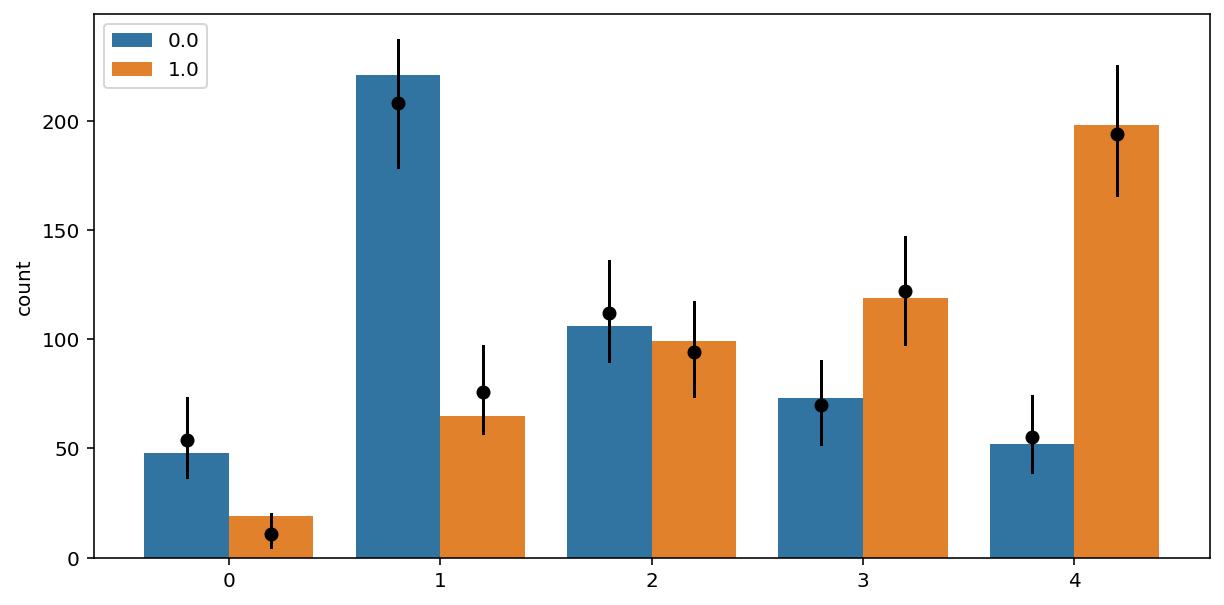

In [33]:
fig, ax = plt.subplots(figsize=(10,5))

# plot observed bin counts
sns.countplot(x=y, hue=group, ax=ax);

# plot errorbars for each group
for offset, g in zip([-0.2, 0.2], [0, 1]):
    ypp_stats = calc_y_stats(ppc["y_obs"][:,group==g], K)
    ax.plot(np.arange(K+1) + offset, ypp_stats[1,:], 'ko')
    # iterate over groups (i.e. bars)
    for i in [0, 1, 2, 3, 4]:
        ax.plot(np.array([i, i])+offset, [ypp_stats[0,i], ypp_stats[2,i]], 'k')

In [34]:
?pm.OrderedProbit

Init signature: pm.OrderedProbit(eta, cutpoints, *args, **kwargs)
Docstring:     
Ordered Probit log-likelihood.

Useful for regression on ordinal data values whose values range
from 1 to K as a function of some predictor, :math:`\eta`. The
cutpoints, :math:`c`, separate which ranges of :math:`\eta` are
mapped to which of the K observed dependent variables.  The number
of cutpoints is K - 1.  It is recommended that the cutpoints are
constrained to be ordered.

In order to stabilize the computation, log-likelihood is computed
in log space using the scaled error function `erfcx`.

.. math::

   f(k \mid \eta, c) = \left\{
     \begin{array}{l}
       1 - \text{normal_cdf}(0, \sigma, \eta - c_1)
         \,, \text{if } k = 0 \\
       \text{normal_cdf}(0, \sigma, \eta - c_{k - 1}) -
       \text{normal_cdf}(0, \sigma, \eta - c_{k})
         \,, \text{if } 0 < k < K \\
       \text{normal_cdf}(0, \sigma, \eta - c_{K - 1})
         \,, \text{if } k = K \\
     \end{array}
   \right.

Parame